# Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, auc, precision_score, recall_score, precision_recall_curve

# Dataset

In [16]:
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

In [17]:
# Checking if there is NULL values anywhere in the dataset
print('Null values in Dataset : ',int(np.any(dataset.isna().any())))

# Scaling 'Amount' Feature since its having a different range 
dataset['Amount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1,1))

# Features
X = dataset.drop(['Time','Class'], axis=1) # Dropping Time since its of no use
# Target Class
y = dataset['Class']

print('Number of Observations in the dataset : ', X.shape[0])
print('Number of Features to be used : ', X.shape[1])
print(f'Fraud cases : {sum(y)}         {np.round(sum(y)/X.shape[0]*100, 3)}%')

Null values in Dataset :  0
Number of Observations in the dataset :  284807
Number of Features to be used :  29
Fraud cases : 492         0.173%


# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('-------------- Training Data --------------')
print(f'X train : {X_train.shape}       y train : {len(y_train)}')
print(f'Fraud cases : {sum(y_train)}         {np.round(sum(y_train)/X_train.shape[0]*100, 3)}%')
print('---------------- Test Data ----------------')
print(f'X test : {X_test.shape}        y test : {len(y_test)}')
print(f'Fraud cases : {sum(y_test)}          {np.round(sum(y_test)/X_test.shape[0]*100, 3)}%')
ROC, precision_recall = {}, {}

-------------- Training Data --------------
X train : (227845, 29)       y train : 227845
Fraud cases : 394         0.173%
---------------- Test Data ----------------
X test : (56962, 29)        y test : 56962
Fraud cases : 98          0.172%


# Combining :
     Oversampling minority class using RandomOverSampler 
     Undersampling majority class using NearMiss

In [19]:
#over = SMOTE(sampling_strategy=0.7, random_state=42)
over = RandomOverSampler(sampling_strategy=0.4, random_state=42)
X_res, y_res = over.fit_resample(X_train, y_train)
print('Oversampled dataset shape %s' % Counter(y_res))

# Undersampling Majority class using Near Miss
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_res, y_res = under.fit_resample(X_res, y_res)
print('Undersampled dataset shape %s' % Counter(y_res))

Oversampled dataset shape Counter({0: 227451, 1: 159215})


# Helper function to train models and report performance metrics

In [20]:
def report(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #print(classification_report(y_test, y_pred))
    
    print("------------------ Test Scores -----------------")
    mean_precision = np.round(precision_score(y_test, y_pred), 4)
    print("mean precision score : {:.4f}".format(mean_precision))
    mean_recall = np.round(recall_score(y_test, y_pred), 4)
    print("mean recall score : {:.4f}".format(mean_recall))
    accuracy = np.round(accuracy_score(y_test, y_pred)*100, 3)
    print("accuracy score : {:.3f}".format(accuracy))

    # compute precision, recall, auc_pr curve
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_pr = round(auc(recall, precision), 3)
    
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot()
    plt.show()

    # return precision,recall and auc_pr curve
    return [precision, recall, auc_pr]


# Random Forest Classifier

------------------ Test Scores -----------------
mean precision score : 0.9121
mean recall score : 0.8469
accuracy score : 99.960


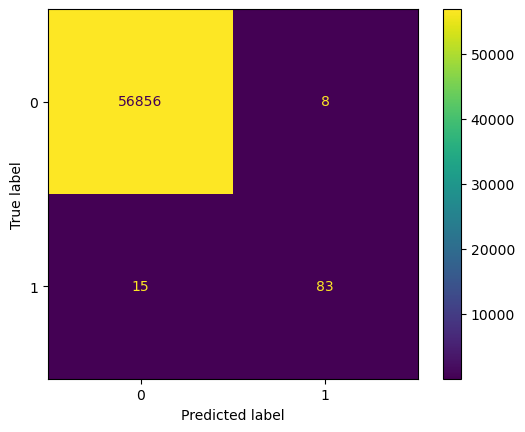

In [21]:
model = RandomForestClassifier(random_state=42)
precision_recall['RandomForest'] = report(model, X_res, X_test, y_res, y_test)

# XGBoost Classifier

------------------ Test Scores -----------------
mean precision score : 0.3074
mean recall score : 0.8878
accuracy score : 99.637


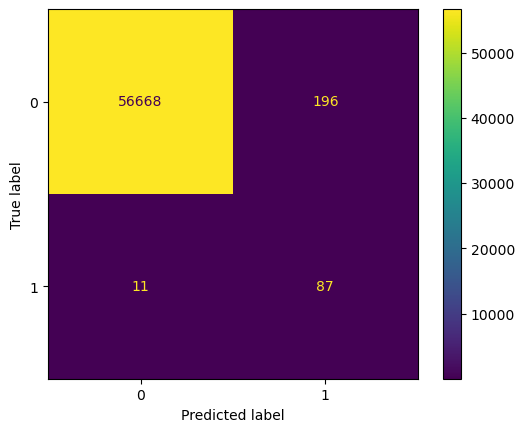

In [22]:
model = XGBClassifier(max_depth=3, random_state=42)
precision_recall['XGBoost'] = report(model, X_res, X_test, y_res, y_test)

# Voting Classifier

------------------ Test Scores -----------------
mean precision score : 0.6992
mean recall score : 0.8776
accuracy score : 99.914


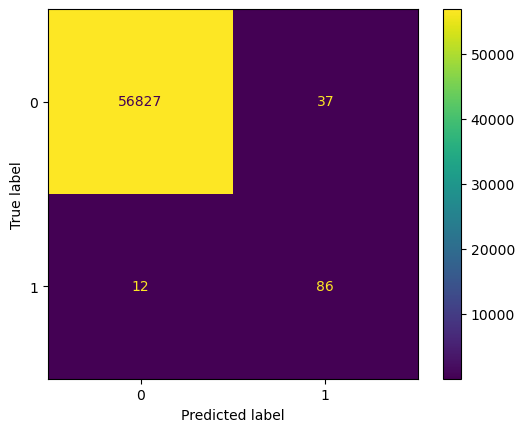

In [23]:
''' Cell Run-time : 10min '''
clf1 = LogisticRegression(penalty="l2", max_iter=500, random_state=12)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors=5)

model = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('gnb', clf3), ('knn', clf4)], voting="soft")
precision_recall['VotingClassifier'] = report(model, X_res, X_test, y_res, y_test)

# Neural Network - MLP Classifier

------------------ Test Scores -----------------
mean precision score : 0.6957
mean recall score : 0.8163
accuracy score : 99.907


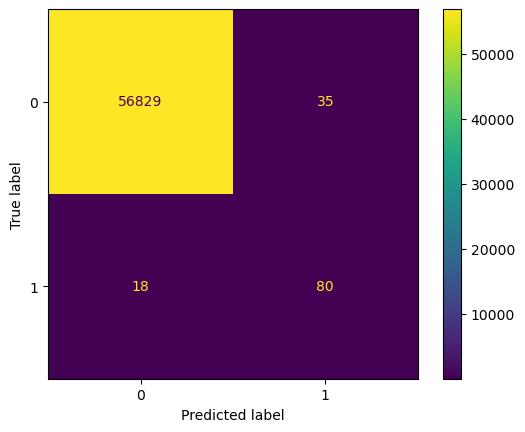

In [24]:
# --------------------------- Default Parameters -----------------------------
# SGD optimizer, uses CrossEntropyLoss, batch_size=200, lr=0.001, max_iter=200, 
# shuffle=true, l2 alpha=0.0001, hidden layer=100, activation=ReLu
model = MLPClassifier(random_state=46, hidden_layer_sizes=(100, 50))
precision_recall['NeuralNetwork'] = report(model, X_res, X_test, y_res, y_test)

# Precision Recall Curve

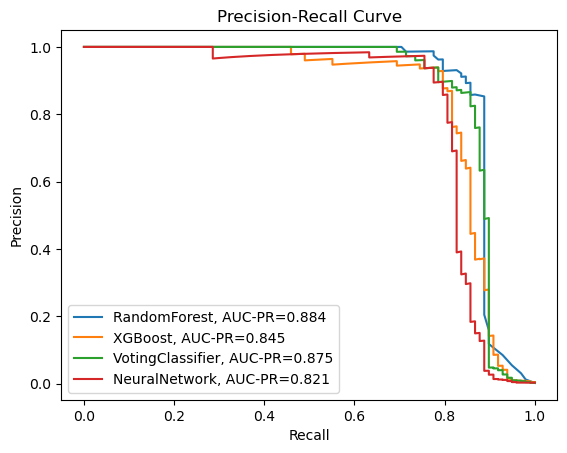

In [25]:
# --------------------------------------------- Precision Recall curve ------------------------------------------------
# Precision -> TP/(TP+FP) -> proportion of correctly predicted +ve class out of all predicted +ve class
# recall/TPR/Sensitivity  -> TP/(TP+FN) -> proportion of correctly predicted +ve class out of all true +ve observations

fig, ax = plt.subplots()
for model in precision_recall:

    # ---------------- recall ------------------- precision -------------------
    ax.plot(precision_recall[model][1],precision_recall[model][0], 
    label=model+", AUC-PR="+str(precision_recall[model][2]))
    
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title("Precision-Recall Curve")
plt.legend(loc=3)
plt.show()